##Detection Of Pneumonia

In [ ]:
#Import all the necessary modules
from google.colab import files
import os
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import glob
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
#Generate the token from kaggle and download the dataset.

files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
os.chdir('/content')
!mkdir bw
!unzip -q chest-xray-pneumonia -d bw/

In [ ]:
dir = '/content/bw/chest_xray/train/NORMAL' #Normal 0
data_path = os.path.join(dir,'*g')
files1 = glob.glob(data_path)

dir = '/content/bw/chest_xray/train/PNEUMONIA' #Pneumonia 1
data_path = os.path.join(dir,'*g')
files2 = glob.glob(data_path)


In [ ]:
#Process 500 images for the training, the number can be increased upto 1300 , 3800 respectively
  
data = []
c = 0
for i in tqdm((files1),'Loading'):
    if c > 500:
        break
    img = cv2.imread(i) 
    img = cv2.resize(img,(299,299))
    img = img/255
    data.append(img)
    c+=1
c = 0    
for i in tqdm((files2),'Loading'):
    if c > 500:
        break
    img = cv2.imread(i) 
    img = cv2.resize(img,(299,299))
    img = img/255
    data.append(img)
    c+=1

In [ ]:
data = np.array(data)
data.shape

In [ ]:
#Visualize the processed images
plt.imshow(data[0])
plt.show() 

In [ ]:
#Process the labels
y1 = np.zeros(501, dtype = int)
y2 = np.ones(501, dtype = int)

y = np.append(y1,y2)
y = y.reshape((1002,1))

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

Y = convert_to_one_hot(y,2).T
Y = np.array(Y,dtype = int)

#Shuffle the dataset 
X, Y = shuffle(X, Y)

#Fine-tune InceptionV3 on a new set of classes

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit(x = X,y = Y,batch_size = 32,epochs = 10)

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')
model.fit(x = X,y = Y,batch_size = 32,epochs = 10)

#save the model
model.save('model.h5')

#later on load the model by 
#model = tf.keras.models.load_model('model.h5') for later use

In [ ]:
#function to identify the vector
def pred(img):
    if (img[0][0] > img[0][1]): #Simple if-else we can also use np.argmax to find the value
        print("Normal")
    else:
        print("PNEUMONIA")

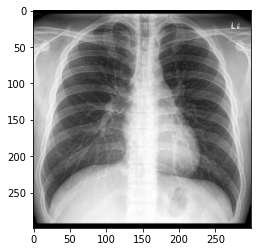

In [ ]:
#download an image resize it by (299,299,3)
img = cv2.imread('/content/332aa0c67cb2e035e372c7cb3ceca2_jumbo.jpg') 
img = cv2.resize(img,(299,299))
img = img/255
plt.imshow(img)

In [ ]:
pred(model.predict(img.reshape(1,299,299,3)))  #call the pred function

PNEUMONIA


In [ ]:
model.save('lawda.h5')